# UV-Guider alignement with source in autocoll
##  Field 4

In [1]:
%matplotlib inline

from __future__ import division, print_function

import sys
sys.path.insert(1, '../../Calibration')
sys.path.append( '../../FireBallPipe')
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table
import matplotlib.patches as patches

from guider2UV.guider2UV import Guider2UV, diff_skycoord

from Calibration.mapping import Mapping

In [2]:
cloudpath = '/home/dvibert/ownCloud/FIREBALL/'
cloudpath = '/Users/Vincent/Nextcloud/LAM/FIREBALL/'

path_SC_GUI02 = cloudpath + 'Tests-at-FortSumner/170909_SC_GUI02/'

#mask_plate_scale = 42.26134 #mm/deg

#detector platescale
#yscale = 1.106 # arcsec/pix spatial (y det -> y mask)
#xscale = 1.271 # arcsec/pix spectral (x det -> - x mask)

#guider center => put source on guider center
gc = np.array([640, 540])

## calibrated frame encoder gains:

EL : 0.092 x 1.00379 = 0.09469 arcsec/inc

CE : 0.01 x 1.02928 = 0.010293 arcsec/inc

In [3]:
# encoder gains:

CEg = 1.02928
Elg = 1.00379

# 2018 calibrated gains put in CNES software
#CEg = 1.0
#Elg = 1.0

## initialization from last xy calib

In [4]:
G2UV = Guider2UV(filename=path_SC_GUI02 + 'Guider2UV_F4_nogamma.new.pkl')
gc_coord = G2UV.GuiderP.pix2local([gc])

target_filename = cloudpath+'Target_selection/targets_F4.txt'
target_filename = '/Users/Vincent/Github/FireBallPipe/Calibration/Targets/targets_F4.txt'
F4 = Table.read(target_filename, format='ascii')

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    (0.18585616, 0.01856568)>
FOV center pixel position in guider [array(1377.264363), array(605.11696717)]


## Diffuse UV image

load new mapping

In [5]:
diffuse_path = cloudpath+'TestsFTS2018-Flight/AIT-Optical-FTS-2018-Flight/XYCalibration/DiffuseMasksIllumination180823/'
diffuse_path = cloudpath+'TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/DiffuseMasksIllumination180823/'

diffuse_tab_file = diffuse_path + 'StackedImage_44-63-NoDark_table.csv'
diffuse_tab = Table.read(diffuse_tab_file, format='csv')
mask_det_map_file = '/home/dvibert/work/FireBallPipe/mapping-mask-det-180823-F4.pkl'
mask_det_map_file = '/Users/Vincent/Github/FireBallPipe/Calibration/Mappings/mapping-mask-det-w-1806012-F4.pkl'
mask_det_map = Mapping(mask_det_map_file)
dxm_dyd = -0.013
dym_dxd = -0.015
m = np.array([[0., dxm_dyd],[dym_dxd ,0.]])

record shift from mapping

positive: current diffuse -> mapping (old diffuse)

In [6]:
diffuse_offset = [ 16.0+1, 1.8+1] 
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## Scan sequence

gc - 31 - 40 - 44 - 33 - 23 - 6  - 8 - 13 - gc - s18 - s29 - s34 - s14 - gc

### Go from guider to 1st slit: #31

In [7]:
slit_pos1 =   np.array([F4[F4['Internal-count']=='31']['xmm'][0], F4[F4['Internal-count']=='31']['ymm'][0]])

print("slit position in mm on mask:", slit_pos1)
slit_coord1 = G2UV.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame:", slit_coord1.to_string(u'dms'))

#frame move
theta_EL =  slit_coord1.lon.deg/2./Elg
theta_CE = -slit_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [ 4.853195 -3.812219]
slit coord in guider local frame: ['0d05m48.03789274s -0d05m49.86729775s']
EL: [173.36190475] arcsec 
CE: [169.95729916] arcsec


### Go from guider to 1st slit: #31

remove offset from model to prediction

In [17]:
slit_coord1_det = direct_map(0.2139, slit_pos1[0], slit_pos1[1])
# slit_coord1_det = direct_map(mask_det_map.w[1], slit_pos1[0], slit_pos1[1])
print("mapped slit position on detector: ", slit_coord1_det)

mapped slit position on detector:  [1434.8650639   585.43183891]


In [18]:
# compute observed position on mask
slit_coord1_obs_det = np.array([1776.2, 623.6]) # observed
slit_coord1_obs_wave = 0.20619
slit_pos1_obs = inv_map(slit_coord1_obs_wave, slit_coord1_obs_det[0], slit_coord1_obs_det[1])
slit_pos1_obs2 = slit_pos1 + m.dot(slit_coord1_obs_det - slit_coord1_det)
print("observed slit position in mm on mask:", slit_pos1_obs)
print("observed slit position (linear mapping) in mm on mask:", slit_pos1_obs2)

slit_coord1_obs = G2UV.SienceMask2guider(slit_pos1_obs, angle=True)
print("observed slit coord in guider local frame:", slit_coord1_obs.to_string(u'dms'))
slit_coord1_obs_pix = G2UV.SienceMask2guider(slit_pos1_obs, angle=False)
print("observed slit coord in guider pixel frame:", slit_coord1_obs_pix)


observed slit position in mm on mask: [ 4.36749312 -3.50296168]
observed slit position (linear mapping) in mm on mask: [ 4.35700891 -8.93224304]
observed slit coord in guider local frame: ['0d06m14.03817827s -0d05m08.18386659s']
observed slit coord in guider pixel frame: [array([1060.29403101]), array([188.59037517])]


In [19]:
offset =  diff_skycoord(slit_coord1_obs, slit_coord1) 
print("offset from guider in arcsec (guider frame): \n",offset*3600)


offset from guider in arcsec (guider frame): 
 [[-26.00028552]
 [-41.68343116]]


In [20]:
G2UVnew  = G2UV.copy()

newFOVcenter = coordinates.SkyCoord(G2UV.FOV_center_guider_coord.lon + offset[0]*u.deg, 
                              G2UV.FOV_center_guider_coord.lat + offset[1]*u.deg,
                              frame = G2UV.GuiderP.localframe)
                     
G2UVnew.FOV_center_guider_coord = newFOVcenter

In [21]:
slit_coord1_cor = G2UVnew.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame, corrected from offset:", slit_coord1_cor.to_string(u'dms'))


slit coord in guider local frame, corrected from offset: ['0d05m22.03760722s -0d06m31.55072891s']


### go back to guider center (absolute)

go to 1st slit, offset removed:

In [22]:

slit_coord1 = G2UVnew.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame:", slit_coord1.to_string(u'dms'))

#frame move
theta_EL =  slit_coord1.lon.deg/2./Elg
theta_CE = -slit_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit coord in guider local frame: ['0d05m22.03760722s -0d06m31.55072891s']
EL: [160.4108465] arcsec 
CE: [190.206129] arcsec


### Loop on slits

In [47]:
slits = ['31', '40', '44', '33', '23', '6', '8', '13'] 
# slits += slits[::-1]
slits

['31', '40', '44', '33', '23', '6', '8', '13']

In [48]:
slit_pos = np.zeros((len(slits),2))
slit_coord = []
slit_coord_pix = np.zeros((len(slits),2))
theta_EL = np.zeros(len(slits))
theta_CE = np.zeros(len(slits))

for i, s in enumerate(slits):
    
    slit_pos[i] = np.array([F4[F4['Internal-count']==s]['xmm'][0], F4[F4['Internal-count']==s]['ymm'][0]])
    print("slit position in mm on mask:", slit_pos[i])
    slit_coord.append(G2UVnew.SienceMask2guider(slit_pos[i], angle=True))
    print("slit coord in guider local frame:", slit_coord[-1].to_string(u'dms'))
    slit_coord_pix[i] = np.array(G2UVnew.SienceMask2guider(slit_pos[i], angle=False)).T
    print("slit coord in guider pixel frame:", slit_coord_pix[i])

    #frame move
    theta_EL[i] =  slit_coord[-1].lon.deg/2./Elg
    theta_CE[i] = -slit_coord[-1].lat.deg/2./CEg
    print("EL: {:.1f} arcsec \nCE: {:.1f} arcsec".format(theta_EL[i]*3600, theta_CE[i]*3600))
    
# compute relative moves
moves_EL = theta_EL[1:] - theta_EL[:-1]
moves_CE = theta_CE[1:] - theta_CE[:-1]


slit position in mm on mask: [ 4.853195 -3.812219]
slit coord in guider local frame: ['0d05m22.03760722s -0d06m31.55072891s']
slit coord in guider pixel frame: [1005.27942863   93.27246029]
EL: 160.4 arcsec 
CE: 190.2 arcsec
slit position in mm on mask: [ 8.811543 -3.028793]
slit coord in guider local frame: ['0d06m31.79464602s -0d12m08.85922001s']
slit coord in guider pixel frame: [1095.87134953 -295.67122476]
EL: 195.2 arcsec 
CE: 354.1 arcsec
slit position in mm on mask: [10.563193  2.136243]
slit coord in guider local frame: ['0d13m53.83688739s -0d14m34.52834313s']
slit coord in guider pixel frame: [1578.8353423  -460.71257556]
EL: 415.3 arcsec 
CE: 424.8 arcsec
slit position in mm on mask: [5.386155 4.42581 ]
slit coord in guider local frame: ['0d17m04.67803191s -0d07m10.4569324s']
slit coord in guider pixel frame: [1759.12344928   42.34695715]
EL: 510.4 arcsec 
CE: 209.1 arcsec
slit position in mm on mask: [ 1.149408 -0.37309 ]
slit coord in guider local frame: ['0d10m12.21897397

In [49]:
# remove middle
idx = np.arange(len(slits)//2)
idx = np.concatenate((idx[:-1], idx[:-1]+len(idx)))
for i in idx:
    print("move:  EL {:.1f} arcsec - CE {:.1f} arcsec".format(moves_EL[i]*3600, moves_CE[i]*3600))


move:  EL 34.7 arcsec - CE 163.9 arcsec
move:  EL 220.2 arcsec - CE 70.8 arcsec
move:  EL 95.1 arcsec - CE -215.7 arcsec
move:  EL 200.5 arcsec - CE -402.3 arcsec
move:  EL -105.8 arcsec - CE 40.3 arcsec
move:  EL -87.3 arcsec - CE 94.8 arcsec


observed slits position :

In [50]:
slit_coord_obs_det = np.zeros((8,2)) + np.array([1800, 421])

slit_coord_obs_det = np.array([[ 1803 ,  421.2 ],
        [ 1469.6 ,  288.7 ],
        [ 1304.2 , 1347.9 ],
        [ 1619.6 ,  1625.4 ],
        [ 1620 ,  1626.6 ],

        [ 1304.3 ,  1355.6 ],
        [ 1469.5 ,  288.7 ],
        [ 1802.9 ,  412.5 ]])
slit_coord_obs_det

array([[1803. ,  421.2],
       [1469.6,  288.7],
       [1304.2, 1347.9],
       [1619.6, 1625.4],
       [1620. , 1626.6],
       [1304.3, 1355.6],
       [1469.5,  288.7],
       [1802.9,  412.5]])

In [73]:
mask_det_map.map(0.2139, slit_pos[:,0], slit_pos[:, 1]).T + diffuse_offset
# mask_det_map.map(mask_det_map.w[1], slit_pos[:,0], slit_pos[:, 1]).T + diffuse_offset
#direct_map(mask_det_map.w[1], slit_pos[:,0].T, slit_pos[:, 1].T)

array([[1434.8650639 ,  585.43183891],
       [1374.06466849,  282.66833213],
       [1023.62132638,  154.47212257],
       [ 880.97041158,  557.86053795],
       [1212.59185429,  874.28735921],
       [ 895.63656053, 1624.99469452],
       [1064.2534211 , 1549.72894175],
       [1203.38665259, 1371.47307296]])

map on mask :

In [52]:
slit_coord_obs_wave = 0.20619    

#slit_pos_obs = mask_det_map.inv_map(slit_coord_obs_wave, slit_coord_obs_det[:,0], slit_coord_obs_det[:,1]).T
slit_pos_obs = inv_map(slit_coord_obs_wave, slit_coord_obs_det[:,0], slit_coord_obs_det[:,1]).T
#print(slit_pos_obs - slit_pos)

#print(slit_coord_obs_wave)
#print(slit_pos_obs)


In [77]:
slit_coord_obs = []
slit_coord_obs_pix = np.zeros((len(slits),2))

# for i, s in enumerate(slit_pos_obs):
for i, s in enumerate(slits):# change vincent
    print("observed slit %i position in mm on mask:"%(i), slit_pos_obs[i])
    slit_coord_obs.append(G2UVnew.SienceMask2guider(slit_pos_obs[i], angle=True))
    print("observed slit %i coord in guider local frame:"%(i), slit_coord_obs[-1].to_string(u'dms'))
    slit_coord_obs_pix[i] = np.array(G2UVnew.SienceMask2guider(slit_pos_obs[i], angle=False)).T
    print("observed slit coord in guider pixel frame:", slit_coord_obs_pix[i])
    print("-------------")


observed slit 0 position in mm on mask: [ 6.9958932  -3.98569701]
observed slit 0 coord in guider local frame: ['0d05m08.83154164s -0d09m34.55986535s']
observed slit coord in guider pixel frame: [ 997.33248824 -117.69146038]
-------------
observed slit 1 position in mm on mask: [8.8177731  0.93034368]
observed slit 1 coord in guider local frame: ['0d12m09.4864078s -0d12m06.12768296s']
observed slit coord in guider pixel frame: [1459.81502663 -290.03807805]
-------------
observed slit 2 position in mm on mask: [-4.89687232  3.70343821]
observed slit 2 coord in guider local frame: ['0d15m54.81768072s 0d07m25.49001266s']
observed slit coord in guider pixel frame: [1686.93209582 1006.77452425]
-------------
observed slit 3 position in mm on mask: [-8.61528237 -0.946206  ]
observed slit 3 coord in guider local frame: ['0d09m15.49131885s 0d12m39.11291293s']
observed slit coord in guider pixel frame: [1274.83650397 1363.72718512]
-------------
observed slit 4 position in mm on mask: [-8.63108

## compute NEW MODEL: orientation, offset & magnification

In [56]:
slit_coord_F = np.zeros((len(slits),2))
slit_coord_obs_F = np.zeros((len(slits),2))

for i in range(len(slits)): #change vincent
# for i in range(len(slit_coord_obs)):
    
    c = G2UVnew.guider_to_FieldLocal(slit_coord[i], angle=True)
    slit_coord_F[i] = np.array([ c.lon.deg, c.lat.deg]).T
    
    c_obs = G2UVnew.guider_to_FieldLocal(slit_coord_obs[i], angle=True)
    slit_coord_obs_F[i] = np.array([ c_obs.lon.deg, c_obs.lat.deg]).T

    
delta = slit_coord_obs_F - slit_coord_F
print(delta*3600)


[[-1.49241395e+01 -1.82885159e+02]
 [ 3.37717405e+02 -4.38683914e-01]
 [ 1.33373011e+02  1.31888260e+03]
 [-4.58019135e+02  1.19397453e+03]
 [-4.94141878e+01  8.34055840e+02]
 [-6.28417102e+01 -3.00495875e+02]
 [-8.57671429e+01 -1.39767262e+03]
 [-3.28242776e+02 -1.05821892e+03]]


In [57]:
row_x = np.hstack((slit_coord_F*[1.,-1], np.ones((8,1)), np.zeros((8,1)) )) # xn -x = x dgamma - y theta + dx
row_y = np.hstack((slit_coord_F[:,::-1], np.zeros((8,1)), np.ones((8,1)) )) # yn - y = x theta - y dgamma 
mat = np.vstack((row_x, row_y))
matinv =  np.linalg.pinv(mat)
data = np.concatenate((delta[:,0], delta[:,1]))
sol = matinv.dot(data)
gama = 1 + sol[0]
theta_rad = sol[1]
deltax = sol[2]
deltay = sol[3]
theta = theta_rad*180/np.pi*60 #arcmin
print("gamma: {}\ntheta: {} arcmin\ndx: {} arcsec\ndy: {} arcsec".format(gama, theta, deltax*3600, deltay*3600))
covar = matinv.dot(matinv.T)
# accuracy, assuming 1 arcsec measurement error
print("variances: {}\n".format(np.sqrt(np.diag(covar))/3600*[1, 180/np.pi*60, 3600, 3600])) #
#residual
data_new = mat.dot(sol) 
print("residuals in arcsec:", (data_new - data)*3600)

gamma: -0.061174855001148165
theta: 849.2557585474365 arcmin
dx: -27.516059820613332 arcsec
dy: -69.91196286597793 arcsec
variances: [5.48046431e-04 1.88404485e+00 3.59260143e-01 3.59260143e-01]

residuals in arcsec: [ 434.44081521   94.62515345 -131.65232302  143.53992789   79.81810224
 -545.79254056 -276.58548238  201.60634717  471.69371996  664.33586432
 -387.13767276 -683.3908304  -807.90713532 -446.83254793  683.51157709
  505.72702504]


Text(-10, 7, 'rotation: 849.26 arcmin\nmagnification -0.0612\ndeltax: 69.9120 arcsec\ndeltay: -27.5161 arcsec')

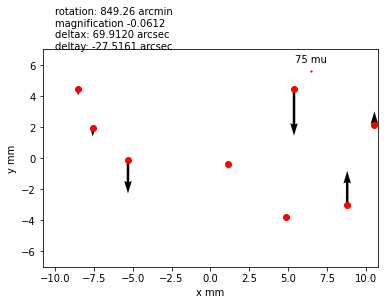

In [58]:
mask_plate_scale = 42.26134
plt.figure()
plt.axis('equal')
plt.plot(slit_pos[:,0], slit_pos[:,1], 'or')
qv = plt.quiver(slit_pos[:,0], slit_pos[:,1], 0., delta[:,0]*mask_plate_scale)
plt.quiverkey(qv, .8,.9,.075, "75 mu", color='r')
plt.xlim([-13, 13])
plt.ylim([-7,7])
plt.xlabel('x mm')
plt.ylabel('y mm')
plt.text(-10,7,"rotation: {:.2f} arcmin\nmagnification {:.4f}\ndeltax: {:.4f} arcsec\ndeltay: {:.4f} arcsec".format(theta, gama, -deltay*3600, deltax*3600))



In [59]:
sit_pos14_obs_det = np.array([1312.8, 1357.7])
slit_pos14_obs = inv_map(slit_coord_obs_wave, sit_pos14_obs_det[0], sit_pos14_obs_det[1]).T
print(slit_pos14_obs, slit_pos[2])

print(G2UV.FieldP.pix2local(slit_pos[2]))
print(G2UV.FieldP.pix2local(slit_pos14_obs))

[-5.02836519  3.57815955] [10.563193  2.136243]
<SkyCoord (SkyOffsetICRS: rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>): (lon, lat) in deg
    (0.05063688, -0.25038687)>
<SkyCoord (SkyOffsetICRS: rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>): (lon, lat) in deg
    (0.08471611, 0.11905102)>


In [60]:
G2UVcor  = Guider2UV(guider_wcs=G2UVnew.GuiderP.w, 
                     Field_center=G2UVnew.FieldP.center, 
                     Field_rotation=G2UVnew.FieldP.rotation,
                     Field_gamma=gama,
                     mask_rotation=G2UVnew.mask_rotation + theta*u.arcmin)


#deltaFOV = - 1/gama*deltax

#G2UVnew  = Guider2UV(guider_wcs=G2UV.GuiderP.w, 
#                     Field_center=G2UV.FieldP.center, 
#                     Field_rotation=G2UV.FieldP.rotation,
#                     Field_gamma=gama)
#                     #mask_rotation=theta*u.arcmin)
#
#deltaFOV = - deltax

newFOVcenter = coordinates.SkyCoord(G2UVnew.FOV_center_guider_coord.lon + deltax*u.deg, 
                              G2UVnew.FOV_center_guider_coord.lat + deltay*u.deg,
                              frame = G2UVnew.GuiderP.localframe)
                     
G2UVcor.FOV_center_guider_coord = newFOVcenter

#G2UVnew.FOV_guider_coord = G2UV.FOV_guider_coord


## check new model on new slit #??

start from last slit #46

In [61]:
slitcheck = '21'
slit_pos5 =   np.array([F4[F4['Internal-count']==slitcheck]['xmm'][0], F4[F4['Internal-count']==slitcheck]['ymm'][0]])

print("slit position in mm on mask:", slit_pos5)
slit_coord5 = G2UVcor.SienceMask2guider(slit_pos5, angle=True)
print("slit coord in guider local frame:", slit_coord5.to_string(u'dms'))
slit_coord5_pix = G2UVcor.SienceMask2guider(slit_pos5, angle=False)
print("slit coord in guider pixel frame:", slit_coord5_pix)

#frame move
theta_EL =  (slit_coord5.lon.deg -  slit_coord[0].lon.deg)/2./Elg
theta_CE = -(slit_coord5.lat.deg -  slit_coord[0].lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [-0.226751  5.705359]
slit coord in guider local frame: ['0d09m46.12297342s -0d00m53.5688165s']
slit coord in guider pixel frame: [array([1287.87410866]), array([473.31418859])]
EL: [131.54413084] arcsec 
CE: [-164.18365868] arcsec


## check new model on known slit #??

start from last slit #14

In [62]:
slits

['31', '40', '44', '33', '23', '6', '8', '13']

In [63]:
slitcheck2 = slits[2]
slit_pos6 =   np.array([F4[F4['Internal-count']==slitcheck2]['xmm'][0], F4[F4['Internal-count']==slitcheck2]['ymm'][0]])

print("slit position in mm on mask:", slit_pos6)
slit_coord6 = G2UVcor.SienceMask2guider(slit_pos6, angle=True)
print("slit coord in guider local frame:", slit_coord6.to_string(u'dms'))
slit_coord6_pix = G2UVcor.SienceMask2guider(slit_pos6, angle=False)
print("slit coord in guider pixel frame:", slit_coord6_pix)

#frame move
theta_EL =  (slit_coord6.lon.deg -  slit_coord5.lon.deg)/2./Elg
theta_CE = -(slit_coord6.lat.deg -  slit_coord5.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [10.563193  2.136243]
slit coord in guider local frame: ['0d09m50.27410018s 0d00m07.52402965s']
slit coord in guider pixel frame: [array([1292.30202511]), array([541.32931779])]
EL: [2.06772669] arcsec 
CE: [-29.67746685] arcsec


compared observed vs diffuse

| wavelength | diffuse   | observed |
|------------|-----------|----------|
| 0.21382    |           |           
| 0.20619    | 1738.3-1531.2| 1754.3x1574.3
| 0.20255    |   |


In [64]:
# compute observed position on mask
slit_coord5_obs_det = np.array([1754.3, 1574.3])
slit_coord5_obs_wave = 0.20619
slit_pos5_obs = mask_det_map.inv_map(slit_coord5_obs_wave, slit_coord5_obs_det[0], slit_coord5_obs_det[1])
print("observed slit position in mm on mask:", slit_pos5_obs)
slit_coord5_obs = G2UVnew.SienceMask2guider(slit_pos5_obs, angle=True)
print("observed slit coord in guider local frame:", slit_coord5_obs.to_string(u'dms'))
slit_coord5_obs_pix = G2UVnew.SienceMask2guider(slit_pos5_obs, angle=False)
print("observed slit coord in guider pixel frame:", slit_coord5_obs_pix)


observed slit position in mm on mask: [-8.0507355  -3.21109152]
observed slit coord in guider local frame: ['0d06m02.79221588s 0d11m49.15474044s']
observed slit coord in guider pixel frame: [array([1062.67180859]), array([1318.89091796])]


## F4 Star sequence

s18 - s29 - s34 - s14 


In [65]:
star_target_path = cloudpath + 'Target_selection/GuidingStars/'
F4_stars = Table.read(star_target_path + "F4_guidingstars.fits", format='fits')
F4_stars_coords = coordinates.SkyCoord(F4_stars['RA']*u.deg, F4_stars['DEC']*u.deg)


### star s18, from guider center

In [66]:
star_pos1_radec = F4_stars_coords[F4_stars['Internal count']==18]
print("star position Ra/Dec: ", star_pos1_radec)
star_coord1 = G2UVnew.SienceMask2guider(star_pos1_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord1)
star_coord1_pix = G2UVnew.SienceMask2guider(star_pos1_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord1_pix)

#frame move
theta_EL =  star_coord1.lon.deg/2./Elg
theta_CE = -star_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.877561, 0.53311)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(0.05903728, 0.03320441)]>
Star position in guider pixel frame:  [array([879.11653979]), array([673.54577459])]
EL: [105.86586903] arcsec 
CE: [-58.06772305] arcsec


observed star position on guider: 896.2 671.0 retour: 895.3x671.5

### star s29

In [67]:
star_pos2_radec = F4_stars_coords[F4_stars['Internal count']==29]
print("star position Ra/Dec: ", star_pos2_radec)
star_coord2 = G2UVnew.SienceMask2guider(star_pos2_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord2)
star_coord2_pix = G2UVnew.SienceMask2guider(star_pos2_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord2_pix)

#frame move
#theta_EL =  star_coord2.lon.deg/2./Elg
#theta_CE = -star_coord2.lat.deg/2./CEg
#print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

theta_EL =  (star_coord2.lon.deg - star_coord1.lon.deg)/2./Elg
theta_CE = -(star_coord2.lat.deg - star_coord1.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.987137, 0.402799)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(-0.07024471, -0.07759171)]>
Star position in guider pixel frame:  [array([353.76231425]), array([215.25627296])]
EL: [-231.8289431] arcsec 
CE: [193.75974755] arcsec


observed star position on guider: aller 373.2 x 227.2 - retour 372.5x217.6

### star s34

In [68]:
star_pos3_radec = F4_stars_coords[F4_stars['Internal count']==34]
print("star position Ra/Dec: ", star_pos3_radec)
star_coord3 = G2UVnew.SienceMask2guider(star_pos3_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord3)
star_coord3_pix = G2UVnew.SienceMask2guider(star_pos3_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord3_pix)

#frame move
#theta_EL =  star_coord2.lon.deg/2./Elg
#theta_CE = -star_coord2.lat.deg/2./CEg
#print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

theta_EL =  (star_coord3.lon.deg - star_coord2.lon.deg)/2./Elg
theta_CE = -(star_coord3.lat.deg - star_coord2.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(37.023638, 0.390844)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(-0.08185662, -0.11420421)]>
Star position in guider pixel frame:  [array([309.20173299]), array([59.75261016])]
EL: [-20.8225283] arcsec 
CE: [64.02776367] arcsec


star pos aller: 328.4x76.3 - retour: 328.0x74.2

### star s14

In [69]:
star_pos4_radec = F4_stars_coords[F4_stars['Internal count']==14]
print("star position Ra/Dec: ", star_pos4_radec)
star_coord4 = G2UVnew.SienceMask2guider(star_pos4_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord4)
star_coord4_pix = G2UVnew.SienceMask2guider(star_pos4_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord4_pix)

#frame move
#theta_EL =  star_coord2.lon.deg/2./Elg
#theta_CE = -star_coord2.lat.deg/2./CEg
#print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

theta_EL =  (star_coord4.lon.deg - star_coord3.lon.deg)/2./Elg
theta_CE = -(star_coord4.lat.deg - star_coord3.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.867454, 0.492628)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(0.01846044, 0.04293117)]>
Star position in guider pixel frame:  [array([715.97692811]), array([714.60307498])]
EL: [179.8889344] arcsec 
CE: [-274.79762006] arcsec


star pos aller: 732.2 710.0 retour: 732.0 718.5

### back to guider center

In [70]:
#frame move
theta_EL =  (0. - star_coord4.lon.deg)/2./Elg
theta_CE = -(0. - star_coord4.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

EL: [-33.10333202] arcsec 
CE: [75.07783189] arcsec
